# Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. They have collected the historical data regarding the house prices in the Austrlia. They want to understand which variables impact the price of the houses and how much those variables impact the house price so that they can strategize their housing business. We will be building the Linear Regression model along with the regularization techniques to understand the same.

In [1]:
# importing the requisite libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
# Reading the dataset and inspecing the first five rows
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Checking the shape of the data
df.shape

(1460, 81)

# Data Cleaning

In [4]:
#Checking the null percentage of the columns
round(100*(df.isnull().sum()/len(df.index)),2).sort_values(ascending = False)

PoolQC           99.52
MiscFeature      96.30
Alley            93.77
Fence            80.75
FireplaceQu      47.26
                 ...  
CentralAir        0.00
SaleCondition     0.00
Heating           0.00
TotalBsmtSF       0.00
Id                0.00
Length: 81, dtype: float64

In [5]:
#Removing the columns where the null percentage is greater than the 80
df.drop(["Alley", "PoolQC", "Fence", "MiscFeature"], axis=1, inplace = True)

In [6]:
'''As per the data dictionary, there are some columns whose NA signifies something. This function takes those column list 
and the corresponding significance of NA value'''
def fill_na_as_per_data_dict(column_names, fill_value):
    for i in range(len(column_names)):
        df[column_names[i]].fillna(fill_value[i], inplace = True)

In [7]:
# Calling the fill_na_as_per_data_dict with the column names and their significance of NA value
column_names = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu",
               "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
fill_value = ["No Basement", "No Basement", "No Basement", "No Basement", "No Basement", "No Fireplace",
             "No Garage", "No Garage", "No Garage", "No Garage"]
fill_na_as_per_data_dict(column_names, fill_value)

In [8]:
# Checking the null percentage again
round(100*(df.isnull().sum()/len(df.index)),2).sort_values(ascending = False).head(7)

LotFrontage    17.74
GarageYrBlt     5.55
MasVnrType      0.55
MasVnrArea      0.55
Electrical      0.07
SalePrice       0.00
ExterCond       0.00
dtype: float64

There are five columns which still has some null values. Out of these three columns, two columns are categorical variables and three are the numeric variables. We will be imputing the categorical variable's null values with the mode and numerical variable's null values with the median

In [9]:
# Function to fill the numeric column's null value with the median
def fill_na_with_median(column_names):
    for column in column_names:
        df[column].fillna(df[column].median(), inplace=True)

In [10]:
# Function to fill the numeric column's null value with the mode
def fill_na_with_mode(column_names):
    for column in column_names:
        df[column].fillna(df[column].mode()[0], inplace=True)

In [11]:
# Calling the fill_na_with_median on the numerical columns
column_names = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
fill_na_with_median(column_names)

In [12]:
# Calling the fill_na_with_mode on the categorical columns
column_names = [ "MasVnrType", "Electrical"]
fill_na_with_mode(column_names)

In [13]:
#Checking the null percentage again
round(100*(df.isnull().sum()/len(df.index)),2).sort_values(ascending = False).head(5)

SalePrice      0.0
ExterCond      0.0
RoofStyle      0.0
RoofMatl       0.0
Exterior1st    0.0
dtype: float64

We sorted the columns by the null percentange in the descending order. And we can see that there are no null values in the dataset now

In [14]:
#Dropping the ID
df.drop("Id", axis=1, inplace = True)

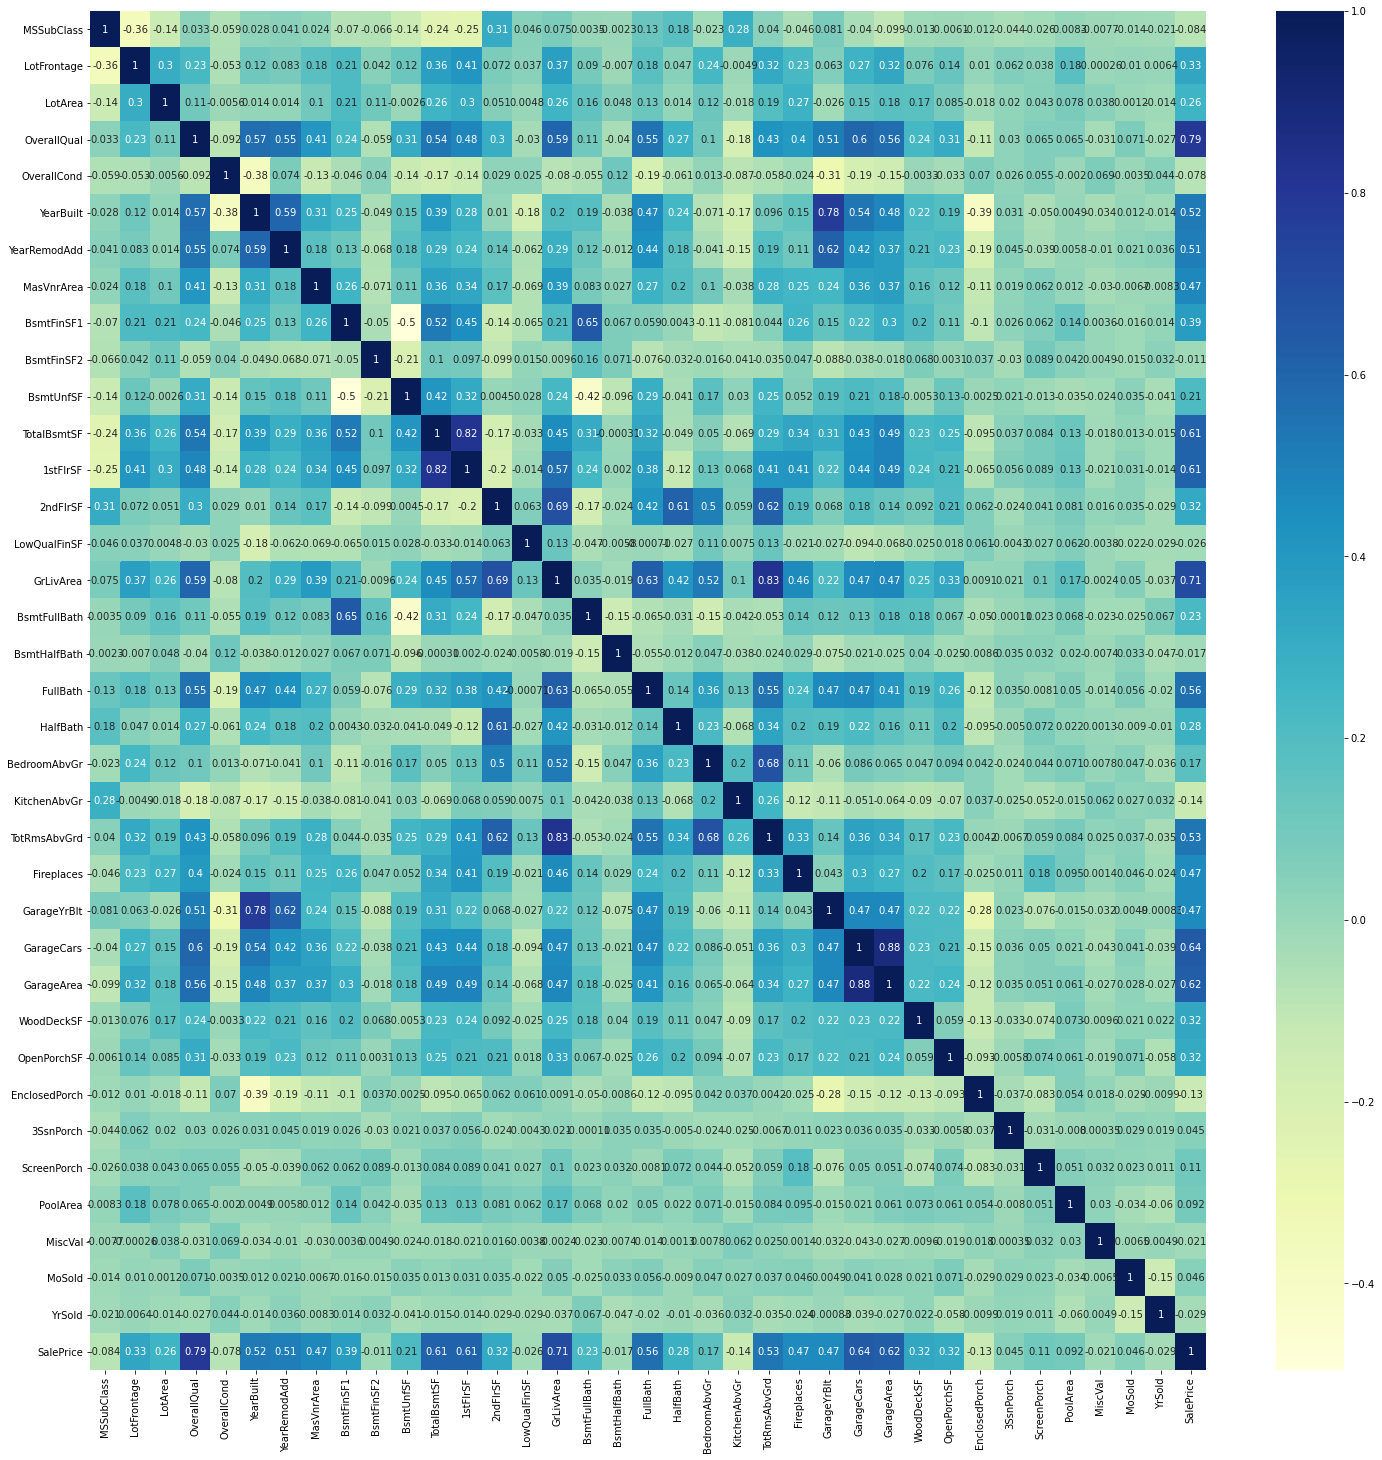

In [15]:
# plotting correlations on a heatmap
cor = df.corr()
# figure size
plt.figure(figsize=(25,25))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

From the above heatmap, we can see that MasVnrArea, 1stFlrSF, GrLivArea, GarageArea are the top correlated numeric variables with the Sale price. We can inspect these columns and clean them.

Note: OverallQual is also showing more correlation with the SalePrice. But the column is a categorical column with the numeric levels. We will encode this column in the later steps.

<AxesSubplot:xlabel='SalePrice'>

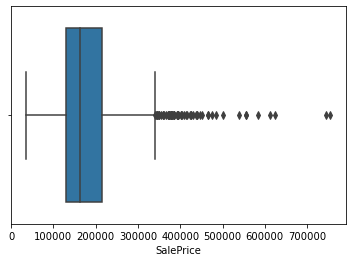

In [16]:
# Plotting the box plot to check whether there are any outliers in the target variable
sns.boxplot(df.SalePrice)

From the above plot, we can see there are some outliers in the data. We will remove the values above 500k

In [17]:
# Removing the rows where the sale price is greater than the 500k
df = df[df.SalePrice<500000]

<AxesSubplot:xlabel='MasVnrArea'>

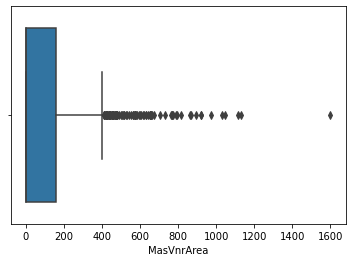

In [18]:
sns.boxplot(df.MasVnrArea)

From the above plot, we can see there are outliers in the data, we will be removing them in the next step

In [19]:
#Removing the outliers from the MasVnrArea
df = df[df.MasVnrArea<1400]

<AxesSubplot:xlabel='1stFlrSF'>

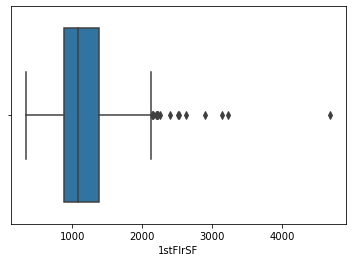

In [20]:
sns.boxplot(df['1stFlrSF'])

From the above plot, we can see there are outliers in the data, we will be removing them in the next step

In [21]:
# Removing the outliers from the 1stFlrSF column
df = df[df['1stFlrSF']<3000]

<AxesSubplot:xlabel='GrLivArea'>

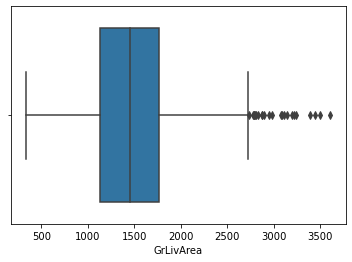

In [22]:
sns.boxplot(df.GrLivArea)

From the above plot, we can see minor outliers in the data, we will be removing them in the next step

In [23]:
#Removing the outliers from the GrLivArea
df = df[df['GrLivArea']<3000]

<AxesSubplot:xlabel='GarageArea'>

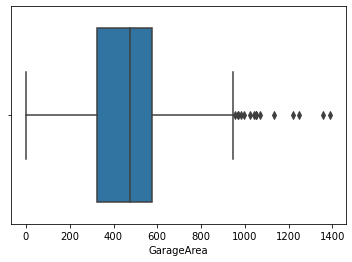

In [24]:
sns.boxplot(df.GarageArea)

From the above plot, we can see there are outliers in the data, we will be removing them in the next step

In [25]:
#Removing the outliers from the GarageArea column
df = df[df['GarageArea']<1100]

In [26]:
#Checking the shape of the data
df.shape

(1431, 76)

We have retained around 98% of the original dataset

 # Derived Metrics

In [27]:
'''Deriving one metric which represents the remodeling status of the house. As per the data dictionary, if the house is 
remodeled, the YearBuilt and YearRemodAdd will be different'''
df.RemodStatus = df.YearBuilt == df.YearRemodAdd

In [28]:
# If the remodling happens, making it 1 else making it 0
df.RemodStatus = df.RemodStatus.apply(lambda x: 1 if x else 0)

# Data Preparation for model building

### Encoding the numerical categorical columns with the categorical values

In [29]:
df['MoSold'] = df['MoSold'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                                7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})

In [30]:
df['CentralAir'] = df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [31]:
df['OverallCond'] = df['OverallCond'].map({1:'Very Poor', 2:'Poor', 3:'Fair', 4:'Below Average', 5:'Average', 
                                           6:'Above Average', 7:'Good', 8:'Very Good', 9:'Excellent', 10:'Very Excellent'})

In [32]:
df['OverallQual'] = df['OverallQual'].map({1:'Very Poor', 2:'Poor', 3:'Fair', 4:'Below Average', 5:'Average', 
                                           6:'Above Average', 7:'Good', 8:'Very Good', 9:'Excellent', 10:'Very Excellent'})

In [33]:
df["MSSubClass"] = df["MSSubClass"].map({20:"1-STORY 1946 & NEWER ALL STYLES", 30:"1-STORY 1945 & OLDER", 
                                         40:"1-STORY W/FINISHED ATTIC ALL AGES", 45:"1-1/2 STORY - UNFINISHED ALL AGES", 
                                         50:"1-1/2 STORY FINISHED ALL AGES", 60:"2-STORY 1946 & NEWER", 
                                         70:"2-STORY 1945 & OLDER", 75:"2-1/2 STORY ALL AGES", 80:"SPLIT OR MULTI-LEVEL", 
                                         85:"SPLIT FOYER", 90:"DUPLEX - ALL STYLES AND AGES", 
                                         120:"1-STORY PUD (Planned Unit Development) - 1946 & NEWER", 
                                         150:"1-1/2 STORY PUD - ALL AGES", 160:"2-STORY PUD - 1946 & NEWER", 
                                         180:"PUD - MULTILEVEL - INCL SPLIT LEV/FOYER", 
                                         190:"2 FAMILY CONVERSION - ALL STYLES AND AGES"})

### Creating the dummy variables

In [34]:
'''Function to create the dummy variables. It creates the dummy variable, drops the first dummy variable, 
concatenates this with the original dataset and removes the original categorical column'''
def create_dummy(dataframe, column_name):
    temp_df = pd.get_dummies(dataframe[column_name], prefix=column_name, drop_first = True)
    dataframe = pd.concat([dataframe, temp_df], axis = 1)
    dataframe.drop([column_name], axis = 1, inplace = True)
    return dataframe

In [35]:
# Categorical columns for which we need to create the dummy variables
cat_df = df.select_dtypes(include = object, exclude = [int, float])
cat_columns = cat_df.columns.values
# Creates the dummy variables
for column in cat_columns:
    df = create_dummy(df, column)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,1,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,1,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,1,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1,...,0,0,0,0,1,0,0,0,1,0


# Model Building - Linear regression

In [36]:
#Splitting the data into the train and test data set
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [37]:
# Scaling the numeric columns
scaler = MinMaxScaler()
columns = list(df_train.columns.values)
columns.remove('CentralAir')
df_train[columns] = scaler.fit_transform(df_train[columns])

In [38]:
df_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
688,0.133562,0.031732,0.985075,0.950000,0.000000,0.502660,0.0,0.202911,0.442608,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1316,0.136986,0.041721,0.992537,0.966667,0.239150,0.000000,0.0,0.694349,0.505926,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
148,0.143836,0.028979,0.962687,0.916667,0.106289,0.361702,0.0,0.171233,0.336868,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1054,0.236301,0.047054,0.947761,0.866667,0.186005,0.495745,0.0,0.056935,0.332190,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1036,0.232877,0.054210,0.985075,0.966667,0.062002,0.543617,0.0,0.255993,0.505303,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
# Splitting the independent and dependent variable. Sale price is the dependent/target variable
y_train = df_train.pop('SalePrice')
X_train = df_train

In [40]:
# Adding the constant to the inpendent variables for the intercept
X_train = sm.add_constant(X_train)

In [41]:
# Fitting the linear regression model on the train data
lm = sm.OLS(y_train,X_train).fit()

In [42]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     55.05
Date:                Wed, 03 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:37:39   Log-Likelihood:                 1908.5
No. Observations:                1001   AIC:                            -3283.
Df Residuals:                     734   BIC:                            -1972.
Df Model:                         266                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

We got the 0.95 R^2 score on the training data. But there are some features whose aren't statistically significant and can be some varibles having multicolinearlity as well. We won't be removing any features here, we will let the regularization technique (lasso and ridge) decrease the significance of the these variables in the model.

# Residual analysis

In [43]:
# Predicting on the train data
y_pred_train = lm.predict(X_train)

Text(0.5, 0, 'Errors')

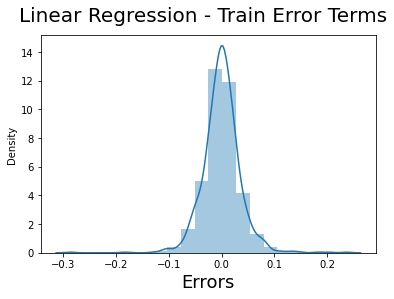

In [44]:
# Plotting the residuals 
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Linear Regression - Train Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

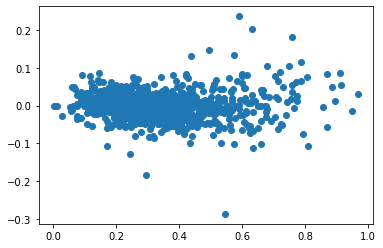

In [45]:
# Plotting the residuals 
res = y_train - y_pred_train
plt.scatter(y_pred_train,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

### Predicting on the test data

In [46]:
#Scaling the test data
columns = list(df_test.columns.values)
columns.remove('CentralAir')
df_test[columns] = scaler.transform(df_test[columns])

In [47]:
# Splitting the dependent and independent variables
y_test = df_test.pop('SalePrice')
X_test = df_test

In [48]:
#Adding the constant to the dependent variables
X_test = sm.add_constant(X_test, has_constant='add')

In [49]:
# Predicting on the test data
y_pred_test = lm.predict(X_test)

In [50]:
# Statistics from the Linear Regression Model
print("Statistics from the Linear Regression Model")
metric1 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)
metric1.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)
metric1.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)
metric1.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)
metric1.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)
metric1.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)
metric1.append(mse_test_lr**0.5)

Statistics from the Linear Regression Model
R^2 of the train data 0.9522655764342344
R^2 of the test data 0.9054673342914131
RSS of the train data 1.2938716058973663
RSS of the test data 0.9682760952562792
RMSE of the train data 0.03595245508822027
RMSE of the test data 0.04745318611736225


The R^2 of the train data is 0.95 and the test data is 0.9. There may be an overfitting. Let's try the Regularization techniques now

Text(0.5, 0, 'Errors')

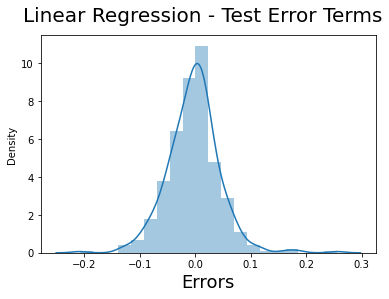

In [51]:
# Plotting the residuals of the test data
fig = plt.figure()
sns.distplot((y_test - y_pred_test), bins = 20)
fig.suptitle('Linear Regression - Test Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

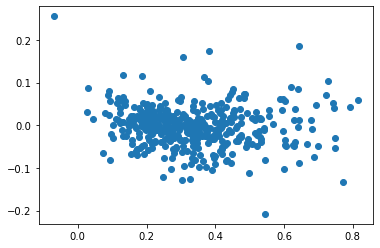

In [52]:
# Plotting the residuals of the test data
res = (y_test - y_pred_test)
plt.scatter(y_pred_test,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

# Ridge regression

In [53]:
# using the GridSearchCV to sweep over different alphas and find the optimum alpha value
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    5.8s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [54]:
print(ridge_model_cv.best_params_)

{'alpha': 3.0}


3.0 is the optimum lambda value of the Ridge regression. Building the regression model with that

In [55]:
# Building the ridge regression with the 3.0 as the lambda and fitting the data
alpha = ridge_model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=3.0)

In [56]:
# Predicting on the train and test data
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

print("Statistics from the Ridge Regression Model")
metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)
metric2.append(mse_test_lr**0.5)

Statistics from the Ridge Regression Model
R^2 of the train data 0.9438744140638293
R^2 of the test data 0.9196437400606046
RSS of the train data 1.5213193452962375
RSS of the test data 0.8230704700888258
RMSE of the train data 0.03898460652296605
RMSE of the test data 0.043750627107500925


Now the train data R^2 is reduced from 0.95 to 0.94 and test data R^2 is increase from the 0.9 to 0.92. Ridge Regression has improved the overfitting situation that has been seen in the normal linear regression model

Text(0.5, 0, 'Errors')

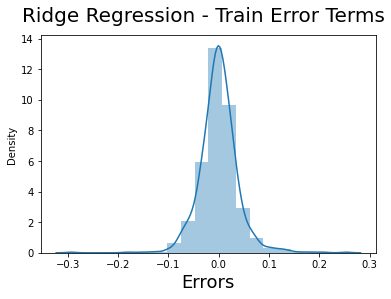

In [57]:
# Plotting the residuals
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Ridge Regression - Train Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

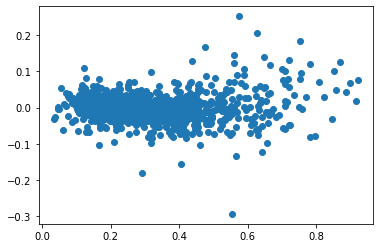

In [58]:
# Plotting the residuals
res = (y_train - y_pred_train)
plt.scatter(y_pred_train,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

Text(0.5, 0, 'Errors')

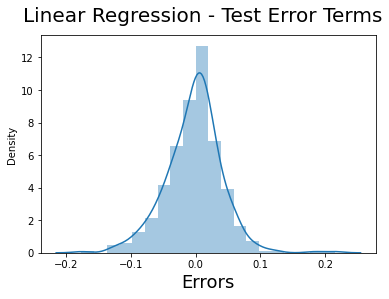

In [59]:
# Plotting the residuals
fig = plt.figure()
sns.distplot((y_test - y_pred_test), bins = 20)
fig.suptitle('Linear Regression - Test Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

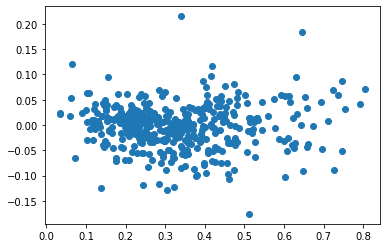

In [60]:
# Plotting the residuals
res = (y_test - y_pred_test)
plt.scatter(y_pred_test,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

# Lasso Regression

In [61]:
# using the GridSearchCV to sweep over different alphas and find the optimum alpha value
lasso = Lasso()

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    7.1s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [62]:
print(lasso_model_cv.best_params_)

{'alpha': 0.0001}


0.0001 is the optimum lambda value for the Lasso Regression

In [63]:
# Building the lasso regression with the 0.0001 as the lambda and fitting the data

alpha = lasso_model_cv.best_params_['alpha']

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [64]:
# Predicting on the train and test data
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

print("Statistics from the Lasso Regression Model")
metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)
metric3.append(mse_test_lr**0.5)

Statistics from the Lasso Regression Model
R^2 of the train data 0.9436391994880683
R^2 of the test data 0.9225718459129948
RSS of the train data 1.5276949844709942
RSS of the test data 0.7930785632701871
RMSE of the train data 0.03906621066414478
RMSE of the test data 0.04294611451331928


The test data R^2 of the lasso regression improved a bit compared to that of the Ridge regression

Text(0.5, 0, 'Errors')

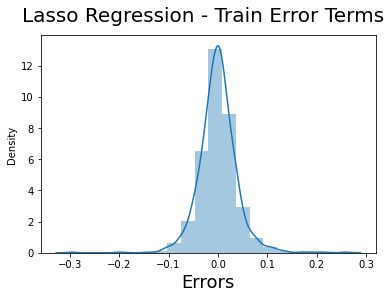

In [65]:
# Plotting the residuals
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
fig.suptitle('Lasso Regression - Train Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

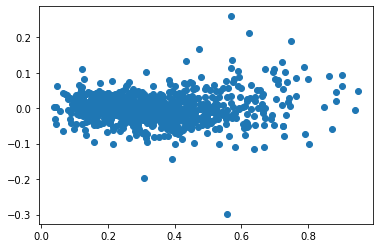

In [66]:
res = (y_train - y_pred_train)
plt.scatter( y_pred_train,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

Text(0.5, 0, 'Errors')

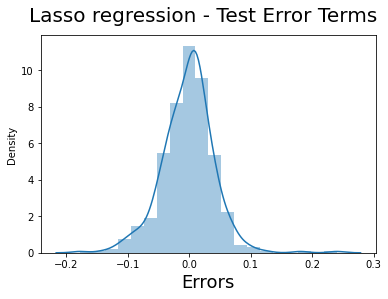

In [67]:
# Plotting the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred_test), bins = 20)
fig.suptitle('Lasso regression - Test Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

From the above diagram, it is clear that the residuals are following the normal distribution and centred around the 0

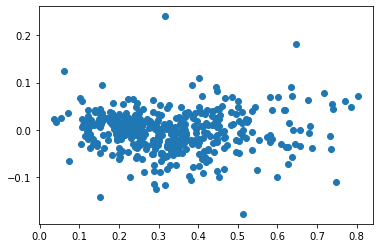

In [68]:
# Plotting the error terms
res = (y_test - y_pred_test)
plt.scatter(y_pred_test,res)
plt.show()

From the above diagram, it is clear that the residuals are not following any pattern and their standard deviation is same across the predictions

In [69]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'RMSE (Train)','RMSE (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.952266,0.943874,0.943639
1,R2 Score (Test),0.905467,0.919644,0.922572
2,RSS (Train),1.293872,1.521319,1.527695
3,RSS (Test),0.968276,0.823070,0.793079
4,RMSE (Train),0.035952,0.038985,0.039066
5,RMSE (Test),0.047453,0.043751,0.042946


From the above table, it is clear that the Lasso Regression has better test R^2, RSS and RMSE values compared with the normal linear regression model and Ridge regression model

In [70]:
'''Creating the table with the beta values for each variable. This table to get the important predictors. 
So that's why taking the absolute value of the coefficients'''
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Linear'] = abs(lm.params)
betas['Ridge'] = abs(ridge.coef_)
betas['Lasso'] = abs(lasso.coef_)

In [71]:
# Top 10 variables as per the Linear regression model
pd.set_option('display.max_rows', None)
betas.sort_values(by='Linear', ascending = False).head(10)

,Linear,Ridge,Lasso
LotArea,0.351936,0.081698,0.202815
Condition2_RRAe,0.193014,0.007887,0.000000
SaleType_New,0.170776,0.046161,0.052773
OverallQual_Very Excellent,0.160217,0.101968,0.174419
GrLivArea,0.151446,0.120570,0.306048
SaleCondition_Partial,0.125571,0.005635,0.000000
Exterior1st_CemntBd,0.120370,0.010119,0.000000
2ndFlrSF,0.120119,0.068280,0.005129
YearBuilt,0.114819,0.049586,0.083852
TotalBsmtSF,0.112529,0.076947,0.121637


In [72]:
# Top 10 variables as per the Ride regression model
pd.set_option('display.max_rows', None)
betas.sort_values(by='Ridge', ascending = False).head(10)

,Linear,Ridge,Lasso
GrLivArea,0.151446,0.120570,0.306048
OverallQual_Very Excellent,0.160217,0.101968,0.174419
1stFlrSF,0.089030,0.094271,0.000000
LotArea,0.351936,0.081698,0.202815
BsmtFinSF1,0.106347,0.078773,0.057293
OverallQual_Excellent,0.094239,0.078148,0.115975
TotalBsmtSF,0.112529,0.076947,0.121637
2ndFlrSF,0.120119,0.068280,0.005129
GarageArea,0.064728,0.059036,0.049167
OverallQual_Very Good,0.062004,0.055296,0.070103


In [73]:
# Top 10 variables as per the Lasso regression model
pd.set_option('display.max_rows', None)
betas.sort_values(by='Lasso', ascending = False).head(10)

,Linear,Ridge,Lasso
GrLivArea,0.151446,0.120570,0.306048
LotArea,0.351936,0.081698,0.202815
OverallQual_Very Excellent,0.160217,0.101968,0.174419
TotalBsmtSF,0.112529,0.076947,0.121637
OverallQual_Excellent,0.094239,0.078148,0.115975
YearBuilt,0.114819,0.049586,0.083852
KitchenAbvGr,0.077486,0.033245,0.081451
OverallQual_Very Good,0.062004,0.055296,0.070103
BsmtFinSF1,0.106347,0.078773,0.057293
Neighborhood_Crawfor,0.044750,0.040508,0.056216


### Final Observations:

1. From the statistics, we have seen that the Lasso regression has the better R^2, RSS and RMSE on the test data. So it is robust and generalising the data.
2. Lasso Regression's optimum lambda is 0.0001 whereas the Ridge regression's optimum lambda is 3.0
3. As per the Lasso Regression, the top 5 variables which are significant in predicting the price of house and how well they predict the house price is as below.

| Predictor | Significane |
|-----------|-------------|
|GrLivArea|0.306048|
LotArea|0.202815
OverallQual_Very Excellent|0.174419
TotalBsmtSF|0.121637
OverallQual_Excellent|0.115975

### Subjective Questions

## Q1 - Double the optimum lambda value

In [74]:
# fitting the data with the double the optimum lambda value which is 6.0 for ridge regression
alpha = ridge_model_cv.best_params_['alpha'] *2
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=6.0)

In [75]:
# Predicting on the train and test data
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

print("Statistics from the Ridge Regression Model with twice the optimal lambda value")
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)


Statistics from the Ridge Regression Model with twice the optimal lambda value
R^2 of the train data 0.938677559314967
R^2 of the test data 0.9195746793656727
RSS of the train data 1.662183365373109
RSS of the test data 0.82377784271524
RMSE of the train data 0.04074951340237793
RMSE of the test data 0.04376942340172147


In [76]:
ridge_coef = pd.DataFrame(index=X_train.columns)
ridge_coef.rows = X_train.columns
ridge_coef['Ridge'] = abs(ridge.coef_)
pd.set_option('display.max_rows', None)
ridge_coef.sort_values(by='Ridge', ascending = False).head(10)

,Ridge
GrLivArea,0.106542
1stFlrSF,0.086080
OverallQual_Very Excellent,0.081443
BsmtFinSF1,0.072165
OverallQual_Excellent,0.069502
TotalBsmtSF,0.068725
2ndFlrSF,0.055882
GarageArea,0.055429
LotArea,0.052058
OverallQual_Very Good,0.051959


There is no much change in the R^2 and RMSE values after building the model with the twice the optimum lambda but there is a change in the top 5 variables after building the model with twice the optimum lambda.

With Optimum Lambda the top5 variables are : GrLivArea, OverallQual_Very Excellent, 1stFlrSF, LotArea and BsmtFinSF1.

With twice the Optimum Lambda the top5 variables are: GrLivArea, 1stFlrSF, OverallQual_Very Excellent, BsmtFinSF1, OverallQual_Excellent	

In [77]:
# fitting the data with the double the optimum lambda value which is 0.0002 for lasso regression
alpha = lasso_model_cv.best_params_['alpha'] * 2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [78]:
# Predicting on the train and test data
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

print("Statistics from the Lasso Regression Model with twice the optimal lambda value")
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)

Statistics from the Lasso Regression Model with twice the optimal lambda value
R^2 of the train data 0.9361577592370822
R^2 of the test data 0.9248244402602436
RSS of the train data 1.730484133032347
RSS of the test data 0.7700057635939976
RMSE of the train data 0.04157830417001988
RMSE of the test data 0.042316794279878715


In [79]:
lasso_coef = pd.DataFrame(index=X_train.columns)
lasso_coef.rows = X_train.columns
lasso_coef['Lasso'] = abs(lasso.coef_)
pd.set_option('display.max_rows', None)
lasso_coef.sort_values(by='Lasso', ascending = False).head(10)

,Lasso
GrLivArea,0.302993
OverallQual_Very Excellent,0.180887
TotalBsmtSF,0.127486
OverallQual_Excellent,0.123973
LotArea,0.117058
OverallQual_Very Good,0.072948
YearBuilt,0.065648
Neighborhood_Crawfor,0.057404
SaleType_New,0.056092
BsmtFinSF1,0.055646


There is no much change in the R^2 and RMSE values after building the model with the twice the optimum lambda but there is a change in the top 5 variables after building the model with twice the optimum lambda. The top5 variables are same in both the cases but the preference order is changed. Below is the top 5 variables in both the cases as per their preference order (depending on the coefficient values).

With Optimum Lambda the top5 variables are : GrLivArea, LotArea, OverallQual_Very Excellent, TotalBsmtSF and OverallQual_Excellent.

With twice the Optimum Lambda the top5 variables are: GrLivArea, OverallQual_Very Excellent, TotalBsmtSF, OverallQual_Excellent, LotArea	

## Q3 - Next top 5 variables for the Lasso regression

In [80]:
# Getting the top 5 variables of the Lasso regression
top5_lasso = list(betas.sort_values(by='Lasso', ascending = False).head(5).index.values)

In [81]:
# Removing those top5 variables from both the training and test datas
X_train_new = X_train.drop(columns = top5_lasso)
X_test_new = X_test.drop(columns = top5_lasso)

In [82]:
# Finding the optimum lambda value using the GridSeachCV for lasso 
lasso = Lasso()

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train_new, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    6.9s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [83]:
print(lasso_model_cv.best_params_)

{'alpha': 0.0001}


The optimum lambda is again 0.0001

In [84]:
#Building the lasso model with 0.0001 lambda and then fitting the data

alpha = lasso_model_cv.best_params_['alpha']

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_new, y_train)

Lasso(alpha=0.0001)

In [85]:
# Predicting on the train and test data
y_pred_train = lasso.predict(X_train_new)
y_pred_test = lasso.predict(X_test_new)

print("Statistics from the Lasso Regression Model after removing the top5 variables")
r2_train_lr = r2_score(y_train, y_pred_train)
print("R^2 of the train data",r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R^2 of the test data",r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS of the train data",rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS of the test data",rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("RMSE of the train data",mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE of the test data",mse_test_lr**0.5)

Statistics from the Lasso Regression Model after removing the top5 variables
R^2 of the train data 0.9360128199402582
R^2 of the test data 0.9148650147034914
RSS of the train data 1.734412803931262
RSS of the test data 0.8720178418190558
RMSE of the train data 0.041625474457445584
RMSE of the test data 0.04503274885399115


In [86]:
# Getting the next top 5 variables
lasso_coef = pd.DataFrame(index=X_train_new.columns)
lasso_coef.rows = X_train_new.columns
lasso_coef['Lasso'] = abs(lasso.coef_)
pd.set_option('display.max_rows', None)
lasso_coef.sort_values(by='Lasso', ascending = False).head(5)

,Lasso
1stFlrSF,0.294236
2ndFlrSF,0.187050
BsmtFinSF1,0.125597
KitchenAbvGr,0.099175
BsmtUnfSF,0.081053


The next top 5 variables are 1stFlrSF, 2ndFlrSF, BsmtFinSF1, KitchenAbvGr and BsmtUnfSF